In [75]:
%load_ext autoreload
%autoreload 2

In [33]:
import torch
import torchvision
import sys
from tqdm import tqdm
import matplotlib.pyplot as plt

sys.path.append('../')
import dataset
# from model import ResNet18YOLOv1
from loss import YOLOv1Loss
import matplotlib.patches as patches

In [34]:
pascal_voc_train = torchvision.datasets.VOCDetection(
    root="../data",
    year="2007",
    image_set="train",
    download=False
)

In [35]:
voc_train = dataset.PascalVOC(pascal_voc=pascal_voc_train)

TRANSFORMING PASCAL VOC


In [36]:
data = voc_train[0]
resize = torchvision.transforms.Resize((448, 448))

data = (resize(data[0]).unsqueeze(0), data[1].unsqueeze(0))

data[0].shape, data[1].shape

(torch.Size([1, 3, 448, 448]), torch.Size([1, 7, 7, 25]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


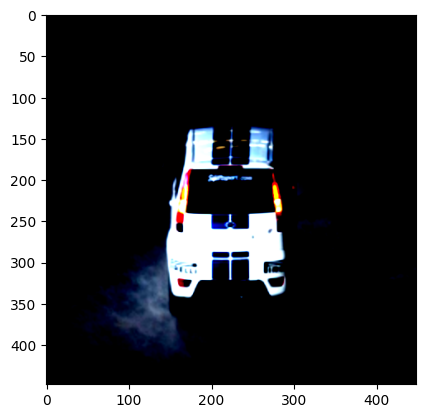

In [37]:
img = data[0].squeeze(0).permute((1, 2, 0))

plt.imshow(img)

In [38]:
Y = data[1][0][3]
Y

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.5490, 0.8574, 0.3900, 0.5195, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
       

In [39]:
device = "cpu"
if torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device("mps")

device

device(type='mps')

In [40]:
# hyperparameters
S = 7
B = 2
C = 20
lambda_coord = 5
lambda_noobj = 0.5

In [41]:
yolo = ResNet18YOLOv1(
    S=7,
    B=2,
    C=20
)

yolo = yolo.to(device)

In [42]:
yolo(data[0].to(device))

tensor([[[[0.4407, 0.6418, 0.4782,  ..., 0.5155, 0.4524, 0.5319],
          [0.3510, 0.4467, 0.5281,  ..., 0.4630, 0.4716, 0.5137],
          [0.6121, 0.2230, 0.5890,  ..., 0.4461, 0.5049, 0.3689],
          ...,
          [0.4653, 0.5261, 0.5666,  ..., 0.4273, 0.5646, 0.6038],
          [0.5580, 0.6108, 0.5185,  ..., 0.4621, 0.5286, 0.4397],
          [0.5886, 0.4635, 0.4356,  ..., 0.4160, 0.4768, 0.5435]],

         [[0.5562, 0.4388, 0.4793,  ..., 0.4176, 0.7050, 0.5637],
          [0.5562, 0.4521, 0.4717,  ..., 0.4938, 0.6074, 0.5986],
          [0.4309, 0.4491, 0.5902,  ..., 0.5185, 0.5351, 0.4883],
          ...,
          [0.4394, 0.6063, 0.4407,  ..., 0.6469, 0.5503, 0.5080],
          [0.4707, 0.5881, 0.3767,  ..., 0.6279, 0.4167, 0.4817],
          [0.5173, 0.5179, 0.4593,  ..., 0.5867, 0.5022, 0.4580]],

         [[0.6054, 0.4885, 0.5492,  ..., 0.4542, 0.4147, 0.4604],
          [0.5533, 0.3760, 0.5491,  ..., 0.5350, 0.5524, 0.4975],
          [0.5782, 0.4860, 0.4154,  ..., 0

In [ ]:
class YOLOv1Loss(nn.Module)

In [43]:
yolo_loss = YOLOv1Loss(lambda_noobj=lambda_noobj)

optimizer = torch.optim.SGD(yolo.parameters(), lr=1e-4, momentum=0.9)
# optimizer = torch.optim.Adam(yolo.parameters(), lr=1e-4)

In [44]:
pred = yolo(data[0].to(device))
target = data[1].to(device)
yolo_loss(pred, target)

obj confidence: 0.026147982105612755, noobj confidence: 12.127052307128906
localization: 0.35561221837997437, confidence: 12.153200149536133, classification: 5.018189430236816


tensor(17.5270, device='mps:0', grad_fn=<DivBackward0>)

In [45]:
EPOCHS = 5

In [47]:
print("TRAINING")

yolo.train()

for epoch in tqdm(range(EPOCHS)):
    X, Y = data
    
    X = X.to(device)
    Y = Y.to(device)
    
    pred = yolo(X)
    loss = yolo_loss(pred, Y)
    
    # backprop
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    print(f"EPOCH {epoch + 1}: Loss={loss}")

TRAINING


  0%|                                                     | 0/5 [00:00<?, ?it/s]

obj confidence: 0.08380303531885147, noobj confidence: 6.345767974853516
localization: 0.05764401704072952, confidence: 6.429571151733398, classification: 1.0247008800506592


 60%|███████████████████████████                  | 3/5 [00:01<00:01,  1.96it/s]

EPOCH 1: Loss=7.511916160583496
obj confidence: 0.05432222783565521, noobj confidence: 4.809910774230957
localization: 0.05842697620391846, confidence: 4.864233016967773, classification: 0.7258515357971191
EPOCH 2: Loss=5.6485114097595215
obj confidence: 0.0845598578453064, noobj confidence: 3.524643898010254
localization: 0.11631691455841064, confidence: 3.609203815460205, classification: 0.6213217377662659
EPOCH 3: Loss=4.346842288970947
obj confidence: 0.011313981376588345, noobj confidence: 2.077871084213257
localization: 0.24526265263557434, confidence: 2.0891849994659424, classification: 0.1580982804298401


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.43it/s]

EPOCH 4: Loss=2.4925458431243896
obj confidence: 0.0014000247465446591, noobj confidence: 1.4903733730316162
localization: 0.21261465549468994, confidence: 1.4917733669281006, classification: 0.08349396288394928
EPOCH 5: Loss=1.7878819704055786


In [25]:
Y = data[1]
Y[0][3][3]

tensor([1.0000, 0.5490, 0.8574, 0.3900, 0.5195, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])

In [26]:
X = data[0]
X

tensor([[[[-0.9498, -0.9587, -0.9765,  ..., -1.1729, -1.2027, -1.2177],
          [-0.9520, -0.9604, -0.9772,  ..., -1.1582, -1.1850, -1.1983],
          [-0.9564, -0.9638, -0.9785,  ..., -1.1289, -1.1494, -1.1597],
          ...,
          [-0.7562, -0.7544, -0.7509,  ..., -0.7217, -0.7242, -0.7254],
          [-0.7283, -0.7281, -0.7277,  ..., -0.7439, -0.7488, -0.7512],
          [-0.7144, -0.7150, -0.7161,  ..., -0.7550, -0.7611, -0.7642]],

         [[-0.8415, -0.8506, -0.8688,  ..., -1.0468, -1.0692, -1.0804],
          [-0.8438, -0.8524, -0.8695,  ..., -1.0318, -1.0510, -1.0606],
          [-0.8483, -0.8558, -0.8709,  ..., -1.0018, -1.0146, -1.0211],
          ...,
          [-0.6611, -0.6603, -0.6587,  ..., -0.6118, -0.6120, -0.6121],
          [-0.6326, -0.6334, -0.6350,  ..., -0.6314, -0.6362, -0.6385],
          [-0.6184, -0.6200, -0.6232,  ..., -0.6412, -0.6483, -0.6518]],

         [[-0.6504, -0.6538, -0.6607,  ..., -0.8313, -0.8576, -0.8708],
          [-0.6527, -0.6562, -

In [27]:
X = data[0].to(device)
pred = yolo(X)[0][3][3]
pred

tensor([0.4910, 0.3367, 0.6746, 0.5537, 0.3036, 0.5816, 0.4972, 0.9809, 0.3908,
        0.5708, 0.0515, 0.0853, 0.1114, 0.0331, 0.1235, 0.0964, 0.9617, 0.1063,
        0.1584, 0.0689, 0.0989, 0.0685, 0.0689, 0.2200, 0.1199, 0.0768, 0.0585,
        0.0796, 0.0525, 0.0452], device='mps:0', grad_fn=<SelectBackward0>)

In [28]:
pred = pred.squeeze(0)
pred.shape

torch.Size([30])

In [29]:
target = pascal_voc_train[0][1]
target

{'annotation': {'folder': 'VOC2007',
  'filename': '000012.jpg',
  'source': {'database': 'The VOC2007 Database',
   'annotation': 'PASCAL VOC2007',
   'image': 'flickr',
   'flickrid': '207539885'},
  'owner': {'flickrid': 'KevBow', 'name': '?'},
  'size': {'width': '500', 'height': '333', 'depth': '3'},
  'segmented': '0',
  'object': [{'name': 'car',
    'pose': 'Rear',
    'truncated': '0',
    'difficult': '0',
    'bndbox': {'xmin': '156', 'ymin': '97', 'xmax': '351', 'ymax': '270'}}]}}

In [30]:
# voc_train[0][1]

In [31]:
pred = pred.view(-1, 30)
pred = pred.detach()
bboxes = []
grid_size = 448 / 7

for i in range(pred.size(0)):
    box_pred = pred[i]
    classification = box_pred[-20:]
    pred_boxes = box_pred[:-20].view(-1, 5)
    
    row = i // 7
    col = i % 7
    
    grid_x = col * grid_size
    grid_y = row * grid_size
    
    for box in pred_boxes:
        confidence = box[0]
        if confidence >= 0.5:
            # change box shape to
            x = box[1]
            y = box[2]
            w = box[3]
            h = box[4]
            
            x_center = grid_x + x * grid_size
            y_center = grid_y + y * grid_size
            width = w * 448
            height = h * 448
            
            xmin = x_center - width / 2
            xmax = x_center + width / 2
            ymin = y_center - height / 2
            ymax = y_center + height / 2
            
            # print(box)
            bbox = torch.tensor([confidence, xmin, ymin, xmax, ymax]) # add classification to this as well
            bboxes.append(bbox)
            print(classification)
            
bboxes = torch.stack(bboxes)
bboxes

tensor([0.0515, 0.0853, 0.1114, 0.0331, 0.1235, 0.0964, 0.9617, 0.1063, 0.1584,
        0.0689, 0.0989, 0.0685, 0.0689, 0.2200, 0.1199, 0.0768, 0.0585, 0.0796,
        0.0525, 0.0452], device='mps:0')


tensor([[  0.5816, -55.7272, -65.0780, 119.3727, 190.6345]])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


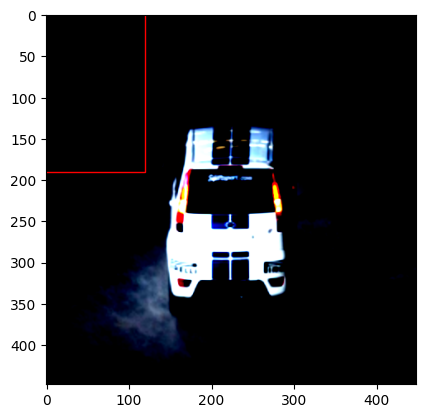

In [32]:
img = data[0].squeeze(0).permute((1, 2, 0))

fig, ax = plt.subplots()

for bbox in bboxes:
    bbox = bbox.numpy()
    xmin = bbox[1]
    ymin = bbox[2]
    width = bbox[3] - xmin
    height = bbox[4] - ymin
    
    rect = patches.Rectangle((xmin, ymin), width, height, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)


ax.imshow(img)